# Initial File trying different unsupervised learning methods on the data
Some things might not be implemented correctly or not work with the data, this was just a starting point.

In [362]:
import pandas as pd
from pandas.plotting import parallel_coordinates

import numpy as np

import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.sparse.csgraph import connected_components, laplacian



# Data Cleaning

In [363]:
# read in the data from csv file
# adjust path to data file
df = pd.read_csv('data/cleaned data/combined_OESdata.csv')

In [364]:
df

,Date,Program Name,Grade,Mode,Burn,Fe,C,Si,Mn,P,...,ID 2,ID 3,Unnamed: 66,Unnamed: 68,Ni_lesser,Ni_greater,Unnamed: 65_lesser,Unnamed: 65_greater,Unnamed: 67_lesser,Unnamed: 67_greater
0,2022-04-28 10:40:58,FE_T_100,4_15,PA,1,98.50,0.173,0.2210,0.5790,0.0187,...,0,0,0.00000,0.00000,0,0,0,0,0,0
1,2022-04-28 10:40:58,FE_T_100,4_15,PA,2.0,98.50,0.174,0.2180,0.5790,0.0168,...,0,0,0.00000,0.00000,0,0,0,0,0,0
2,2022-04-28 10:40:58,FE_T_100,4_15,PA,3.0,98.50,0.178,0.2210,0.5870,0.0188,...,0,0,0.00000,0.00000,0,0,0,0,0,0
3,2022-04-28 09:36:35,FE_T_100,5_15,PA,1,97.80,0.135,0.2650,0.7030,0.0188,...,0,0,0.00000,0.00000,0,0,0,0,0,0
4,2022-04-28 09:36:35,FE_T_100,5_15,PA,2.0,97.80,0.135,0.2620,0.7040,0.0179,...,0,0,0.00000,0.00000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,2021-10-20 15:37:00,FE_T_100,0,PA,2,98.80,0.003,0.2510,0.5320,0.1190,...,0,0,0.00400,0.01000,0,0,1,0,1,0
4472,2021-10-20 15:37:00,FE_T_100,0,PA,3,98.90,0.003,0.2300,0.4860,0.1180,...,0,0,0.00400,0.01000,0,0,1,0,1,0
4473,2021-10-20 15:37:00,FE_T_100,0,PA,0,98.80,0.003,0.2390,0.4990,0.1210,...,0,0,0.00440,0.01200,0,0,0,0,0,0
4474,2021-10-20 15:37:00,FE_T_100,0,PA,SD,0.04,0.000,0.0107,0.0287,0.0053,...,0,0,0.00063,0.00352,0,0,0,0,0,0


In [365]:
# Find rows where 'ID 1' contains an underscore
mask = df['ID 1'].str.contains('_')

# Swap 'ID 1' and 'Grade' values in these rows
df.loc[mask, ['ID 1', 'Grade']] = df.loc[mask, ['Grade', 'ID 1']].values

# FIXME?: keep lesser and greater?
# Identifying columns that contain 'lesser' or 'greater' in their names
columns_to_drop = [col for col in df.columns if 'lesser' in col or 'greater' in col or 'Unnamed' in col]

# FIXME?: keep ID 1 where typ of steel is present for future analysis 
# Adding specific columns to the list
additional_columns = ['Program Name', 'Mode', 'Burn', 'ID 1', 'ID 2', 'ID 3', 'Date']
columns_to_drop.extend(additional_columns)

# Ensuring only columns present in df are attempted to be dropped
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Dropping these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# reduce the number of rows by removing every row without proper grade
df = df[df['Grade'].str.contains('_')]

df.describe()

,Fe,C,Si,Mn,P,S,Cr,Mo,Ni,Al,...,Ti,V,W,Pb,Sn,B,Ca,Zr,As,Bi
count,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,...,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000
mean,87.934302,0.399250,0.394632,0.742406,0.081605,0.169747,0.105990,0.044088,0.143661,0.142156,...,0.143610,0.146802,0.157801,0.108939,0.175579,0.148876,0.001458,0.047457,0.039333,0.019127
std,30.269976,4.297239,2.682326,2.495511,1.684172,3.888860,2.841668,2.288424,2.777156,3.191244,...,3.466998,3.477255,2.937966,2.580680,4.089861,3.659675,0.001538,2.392798,0.019727,0.016982
min,0.000000,0.003000,0.000000,0.006840,0.000000,0.000000,0.000000,0.000000,0.000700,0.000430,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98.000000,0.128000,0.084600,0.502000,0.015100,0.030200,0.005200,0.003000,0.033600,0.002000,...,0.001200,0.001800,0.040000,0.015000,0.007700,0.001500,0.001000,0.002000,0.026400,0.010000
50%,98.400000,0.208000,0.227000,0.615000,0.023300,0.038700,0.011600,0.003500,0.045600,0.002700,...,0.001400,0.002200,0.040000,0.015000,0.013700,0.001900,0.001100,0.002000,0.039500,0.015400
75%,98.700000,0.255000,0.283000,0.702000,0.032500,0.048200,0.022600,0.005100,0.055900,0.005400,...,0.001800,0.002600,0.040000,0.015000,0.019200,0.002300,0.001300,0.002000,0.050000,0.023000
max,99.500000,149.580000,85.040000,78.340000,69.160000,181.740000,120.600000,134.320000,144.660000,146.550000,...,137.610000,133.730000,143.020000,112.500000,147.040000,130.270000,0.010000,139.610000,0.125000,0.126000


# Data Cleaning according to the 'Identifikationsschema' 

In [366]:
# Define the condition for moving rows
condition = (df['Fe'] < 97.0) | (df['S'] > 0.09) | (df['Al'] > 0.075) | (df['Pb'] > 0.06)

# Create df_out with rows that match the condition
df_out = df[condition].copy()

# Add the 'Measuring error' column set to True
df_out['Measuring error'] = True

# Remove the rows from the original df
df = df[~condition]
df.describe()

,Fe,C,Si,Mn,P,S,Cr,Mo,Ni,Al,...,Ti,V,W,Pb,Sn,B,Ca,Zr,As,Bi
count,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,...,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000,2874.000000
mean,98.504036,0.187415,0.243858,0.603558,0.024926,0.038063,0.021933,0.004145,0.051400,0.005750,...,0.001655,0.002364,0.040129,0.015414,0.014616,0.001952,0.001273,0.002388,0.039108,0.017430
std,0.439620,0.083674,0.242040,0.158444,0.014630,0.013587,0.039899,0.001657,0.031861,0.008926,...,0.000964,0.001425,0.003745,0.003306,0.009484,0.000515,0.000856,0.000881,0.016881,0.008046
min,97.000000,0.003000,0.005000,0.050900,0.003000,0.002000,0.005000,0.003000,0.005000,0.002000,...,0.001000,0.001000,0.040000,0.015000,0.002000,0.001000,0.000000,0.002000,0.000000,0.000000
25%,98.300000,0.125000,0.013200,0.493250,0.015025,0.029225,0.007000,0.003000,0.034125,0.002000,...,0.001200,0.001800,0.040000,0.015000,0.007800,0.001600,0.001000,0.002000,0.027500,0.010000
50%,98.500000,0.204000,0.227000,0.601000,0.023000,0.037550,0.012300,0.003400,0.046300,0.002400,...,0.001500,0.002200,0.040000,0.015000,0.013700,0.001900,0.001100,0.002000,0.040750,0.016000
75%,98.800000,0.248000,0.276000,0.694750,0.031475,0.045875,0.023700,0.004800,0.055300,0.004500,...,0.001800,0.002600,0.040000,0.015000,0.018700,0.002200,0.001300,0.002000,0.050400,0.022900
max,99.500000,0.651000,1.420000,1.240000,0.170000,0.089200,0.442000,0.014700,0.287000,0.060900,...,0.017900,0.037100,0.195000,0.058600,0.067700,0.010900,0.010000,0.007100,0.125000,0.095700


In [367]:
# Function to detect outliers in a Series
def find_outliers(series):
    Q1 = series.quantile(0.05)
    Q3 = series.quantile(0.95)
    IQR = Q3 - Q1
    return (series < (Q1 - 3 * IQR)) | (series > (Q3 + 3 * IQR))

# Apply the function to each column of df, except 'Grade'
outliers = df.drop(columns=['Grade']).apply(find_outliers)

# Any row with at least one outlier in the selected columns
rows_with_outliers = outliers.any(axis=1)

# Select rows containing outliers
new_outliers = df[rows_with_outliers].copy()

# Add the 'outlier' column set to True
new_outliers['outlier'] = True

# Append these rows to the existing df_out
df_out = pd.concat([df_out, new_outliers])

# Remove these rows from the original df
df = df[~rows_with_outliers]

new_outliers.describe()

,Fe,C,Si,Mn,P,S,Cr,Mo,Ni,Al,...,Ti,V,W,Pb,Sn,B,Ca,Zr,As,Bi
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,98.220645,0.158060,0.336243,0.676116,0.033010,0.042558,0.090852,0.004309,0.052926,0.018145,...,0.002606,0.003546,0.042400,0.022670,0.012788,0.002188,0.002837,0.002289,0.039152,0.019134
std,0.666908,0.089703,0.330019,0.226077,0.034923,0.015742,0.142196,0.001925,0.031001,0.018228,...,0.002842,0.005214,0.016003,0.012159,0.007935,0.000913,0.002990,0.000804,0.023662,0.011735
min,97.000000,0.003000,0.005000,0.101000,0.003000,0.004900,0.005000,0.003000,0.005000,0.002000,...,0.001000,0.001000,0.040000,0.015000,0.002000,0.001000,0.000000,0.002000,0.000000,0.000000
25%,97.800000,0.081400,0.010700,0.477000,0.014700,0.032950,0.005000,0.003000,0.029800,0.003000,...,0.001300,0.001700,0.040000,0.015000,0.005400,0.001750,0.001000,0.002000,0.024400,0.010000
50%,98.300000,0.157000,0.282000,0.684000,0.021900,0.039700,0.014000,0.003100,0.042900,0.008900,...,0.001600,0.002200,0.040000,0.015700,0.013100,0.002100,0.001400,0.002000,0.041800,0.016800
75%,98.800000,0.210000,0.503500,0.881000,0.034250,0.050050,0.085200,0.005150,0.076550,0.029750,...,0.002550,0.002500,0.040000,0.024600,0.018950,0.002500,0.004350,0.002000,0.057600,0.028700
max,99.300000,0.440000,1.420000,1.190000,0.170000,0.082900,0.442000,0.009600,0.119000,0.060700,...,0.017900,0.037100,0.195000,0.058600,0.031500,0.010900,0.010000,0.006200,0.098300,0.046800


In [368]:
# Remove duplicates
df = df.drop_duplicates()

df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,Fe,C,Si,Mn,P,S,Cr,Mo,Ni,Al,...,Ti,V,W,Pb,Sn,B,Ca,Zr,As,Bi
count,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,...,2197.00000,2197.000000,2.197000e+03,2.197000e+03,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000
mean,98.524716,0.192141,0.233113,0.597875,0.025145,0.038146,0.017940,0.004126,0.050864,0.004730,...,0.00160,0.002305,4.000000e-02,1.500000e-02,0.014544,0.001958,0.001175,0.002398,0.039992,0.017639
std,0.406509,0.081536,0.222070,0.149303,0.012510,0.013149,0.015435,0.001644,0.031620,0.006676,...,0.00068,0.000695,1.152119e-15,3.938719e-16,0.008961,0.000475,0.000315,0.000888,0.015856,0.007902
min,97.300000,0.003000,0.005000,0.050900,0.003000,0.002000,0.005000,0.003000,0.008600,0.002000,...,0.00100,0.001000,4.000000e-02,1.500000e-02,0.002000,0.001000,0.000000,0.002000,0.000000,0.000000
1%,97.596000,0.019096,0.005000,0.279880,0.005396,0.004500,0.005000,0.003000,0.015780,0.002000,...,0.00100,0.001100,4.000000e-02,1.500000e-02,0.002000,0.001000,0.000000,0.002000,0.000000,0.000000
5%,97.800000,0.042500,0.005000,0.371000,0.008680,0.017700,0.005000,0.003000,0.022200,0.002000,...,0.00100,0.001500,4.000000e-02,1.500000e-02,0.002500,0.001300,0.001000,0.002000,0.013200,0.010000
25%,98.300000,0.132000,0.090400,0.494000,0.016000,0.029600,0.007500,0.003000,0.034500,0.002000,...,0.00120,0.001900,4.000000e-02,1.500000e-02,0.008100,0.001600,0.001000,0.002000,0.029300,0.010000
50%,98.500000,0.209000,0.225000,0.595000,0.023600,0.037600,0.012500,0.003400,0.046100,0.002300,...,0.00150,0.002200,4.000000e-02,1.500000e-02,0.014000,0.001900,0.001100,0.002000,0.041600,0.016600
75%,98.800000,0.250000,0.271000,0.691000,0.031900,0.045800,0.023100,0.004800,0.055100,0.004100,...,0.00170,0.002600,4.000000e-02,1.500000e-02,0.018600,0.002200,0.001200,0.002000,0.050600,0.023000
95%,99.200000,0.304000,0.844000,0.843000,0.046860,0.061180,0.051420,0.007100,0.111000,0.017620,...,0.00310,0.003300,4.000000e-02,1.500000e-02,0.030700,0.002800,0.001700,0.004600,0.063920,0.030920


In [369]:
# TODO: find measuring errors and remove them
# FIXME?: remove rows with 'nan' or 0 values in column 'Grade'
# FIXME?: don't group by grade and take the mean
# merge the rows with the same grade
df = df.groupby('Grade').mean()

# reset the index
df = df.reset_index()

# Drop the 'Grade' column
df = df.drop(columns=['Grade'])

In [370]:
df.describe()

,Fe,C,Si,Mn,P,S,Cr,Mo,Ni,Al,...,Ti,V,W,Pb,Sn,B,Ca,Zr,As,Bi
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,...,412.000000,412.000000,4.120000e+02,4.120000e+02,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,98.519061,0.195726,0.239302,0.597264,0.024849,0.038941,0.017248,0.004118,0.050030,0.004944,...,0.001633,0.002289,4.000000e-02,1.500000e-02,0.014373,0.001960,0.001194,0.002394,0.039711,0.017551
std,0.405714,0.082095,0.225617,0.149743,0.012207,0.013007,0.015049,0.001600,0.030736,0.006662,...,0.000702,0.000674,4.237871e-16,8.687143e-17,0.008838,0.000442,0.000323,0.000643,0.015692,0.007132
min,97.300000,0.003933,0.005000,0.055800,0.003000,0.002000,0.005000,0.003000,0.011583,0.002000,...,0.001000,0.001000,4.000000e-02,1.500000e-02,0.002000,0.001000,0.000000,0.002000,0.000000,0.000000
25%,98.300000,0.136750,0.108042,0.498458,0.015900,0.030846,0.007012,0.003013,0.033788,0.002000,...,0.001212,0.001850,4.000000e-02,1.500000e-02,0.007959,0.001667,0.001017,0.002000,0.029063,0.011292
50%,98.483333,0.212667,0.226833,0.593333,0.023433,0.038717,0.012033,0.003586,0.045308,0.002667,...,0.001458,0.002167,4.000000e-02,1.500000e-02,0.013962,0.001933,0.001117,0.002017,0.041450,0.016850
75%,98.700000,0.252500,0.274563,0.693542,0.031233,0.047212,0.021571,0.004567,0.054967,0.004406,...,0.001742,0.002600,4.000000e-02,1.500000e-02,0.018250,0.002217,0.001254,0.002533,0.050800,0.021708
max,99.466667,0.539000,1.091667,1.226667,0.088414,0.082700,0.109000,0.013417,0.282333,0.054733,...,0.006033,0.006757,4.000000e-02,1.500000e-02,0.067400,0.003700,0.003733,0.007100,0.092533,0.060100


In [371]:
df_out = df_out.reset_index()
df_out = df_out.drop(columns=['index'])
df_out.describe()

,Fe,C,Si,Mn,P,S,Cr,Mo,Ni,Al,...,Ti,V,W,Pb,Sn,B,Ca,Zr,As,Bi
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,...,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,48.288251,1.186341,0.979029,1.277907,0.295605,0.663889,0.435511,0.193715,0.489522,0.655668,...,0.675457,0.687998,0.598989,0.460756,0.778021,0.699182,0.002484,0.216231,0.040188,0.025846
std,48.556225,9.322514,5.791178,5.397393,3.662699,8.457547,6.182289,4.984836,6.040025,6.931300,...,7.532637,7.554220,6.384068,5.610689,8.888084,7.952244,0.003073,5.211706,0.028936,0.032955
min,0.000000,0.003000,0.000000,0.006840,0.000000,0.000000,0.000000,0.000000,0.000700,0.000430,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.140500,0.122000,0.542000,0.015425,0.034425,0.005000,0.003000,0.031125,0.002500,...,0.001100,0.001800,0.040000,0.015000,0.006425,0.001000,0.001000,0.002000,0.023725,0.010000
50%,3.320000,0.225000,0.242500,0.649000,0.024600,0.045350,0.005100,0.004200,0.041600,0.005700,...,0.001400,0.002200,0.040000,0.015000,0.013750,0.001300,0.001000,0.002000,0.035200,0.011700
75%,97.900000,0.299750,0.433250,0.768250,0.042100,0.091775,0.019675,0.007175,0.061750,0.024175,...,0.003200,0.002700,0.040000,0.025500,0.023175,0.003600,0.001900,0.002000,0.048700,0.026200
max,99.300000,149.580000,85.040000,78.340000,69.160000,181.740000,120.600000,134.320000,144.660000,146.550000,...,137.610000,133.730000,143.020000,112.500000,147.040000,130.270000,0.010000,139.610000,0.125000,0.126000


# PCA

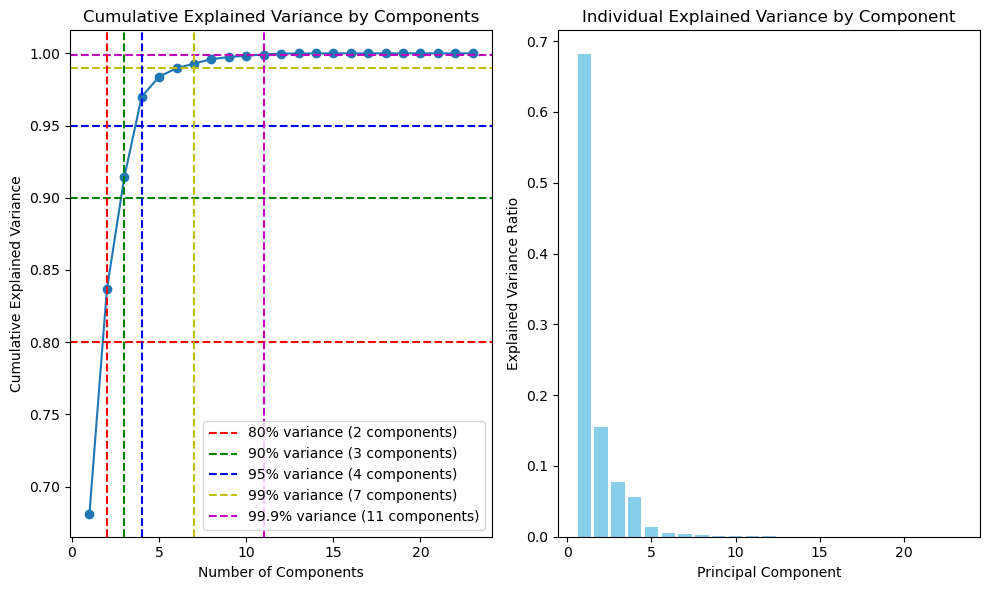

In [372]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Fitting PCA
pca = PCA()
pca.fit(df_scaled)

# Calculating cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Finding the number of components for 80%, 90%, 95% and 99% of explained variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
n_components_999 = np.argmax(cumulative_variance >= 0.999) + 1

# Plotting
plt.figure(figsize=(10, 6))

# Plotting the cumulative explained variance
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Components')

# Adding horizontal lines for 80%, 90%, 95% and 99% thresholds
plt.axhline(y=0.80, color='r', linestyle='--')
plt.axhline(y=0.90, color='g', linestyle='--')
plt.axhline(y=0.95, color='b', linestyle='--')
plt.axhline(y=0.99, color='y', linestyle='--')
plt.axhline(y=0.999, color='m', linestyle='--')


# Adding vertical lines to mark the component count
plt.axvline(x=n_components_80, color='r', linestyle='--', label=f'80% variance ({n_components_80} components)')
plt.axvline(x=n_components_90, color='g', linestyle='--', label=f'90% variance ({n_components_90} components)')
plt.axvline(x=n_components_95, color='b', linestyle='--', label=f'95% variance ({n_components_95} components)')
plt.axvline(x=n_components_99, color='y', linestyle='--', label=f'99% variance ({n_components_99} components)')
plt.axvline(x=n_components_999, color='m', linestyle='--', label=f'99.9% variance ({n_components_999} components)')

plt.legend()

# Plotting individual explained variance
plt.subplot(1, 2, 2)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance by Component')

plt.tight_layout()
plt.show()


# K-means Clustering

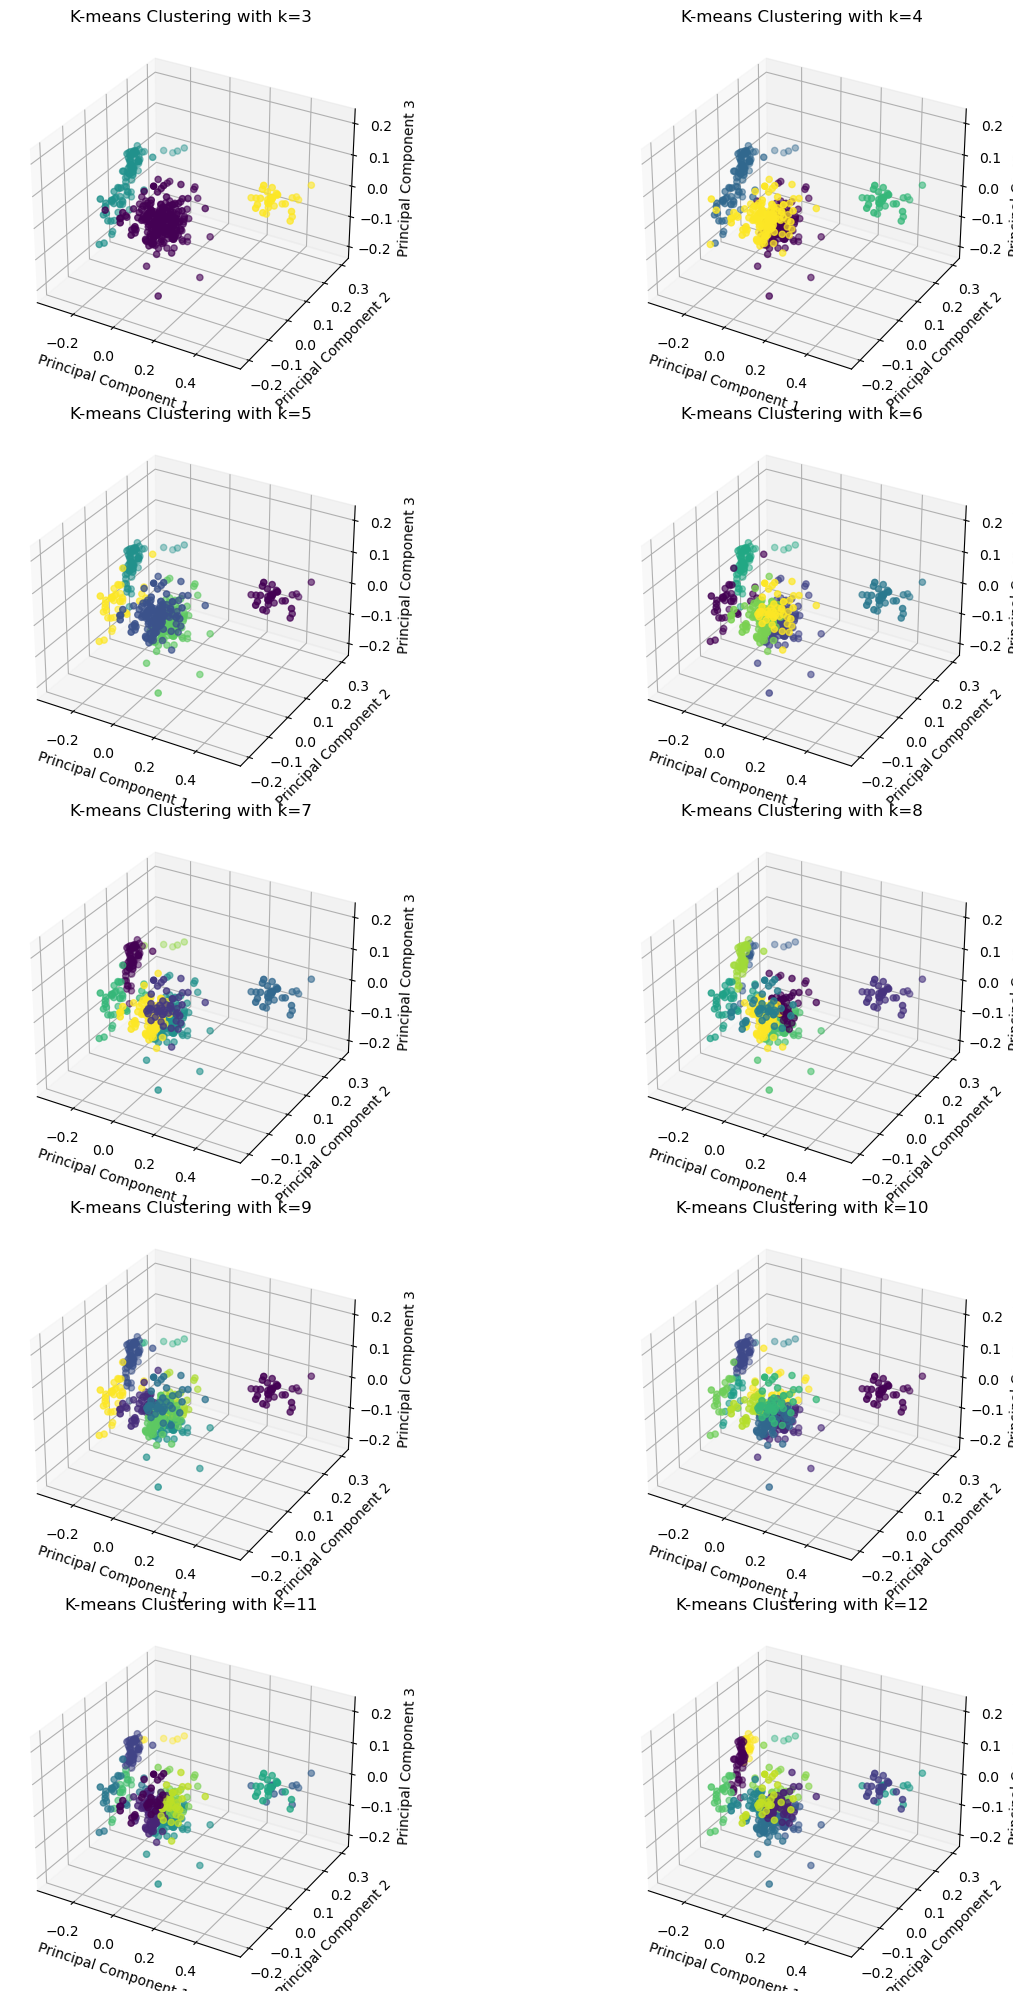

In [373]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Applying PCA to reduce dimensions to 3
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(df_scaled)

# Number of subplots
num_plots = 10  # for k from 3 to 12

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 20))

for i, k in enumerate(range(3, 13)):
    # Applying K-means clustering
    kmeans = KMeans(n_clusters=k, n_init=10)
    clusters = kmeans.fit_predict(reduced_data)

    # Adding a 3D subplot for each k
    ax = fig.add_subplot(5, 2, i+1, projection='3d')
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=clusters, cmap='viridis', marker='o')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(f'K-means Clustering with k={k}')

plt.tight_layout()
plt.show()

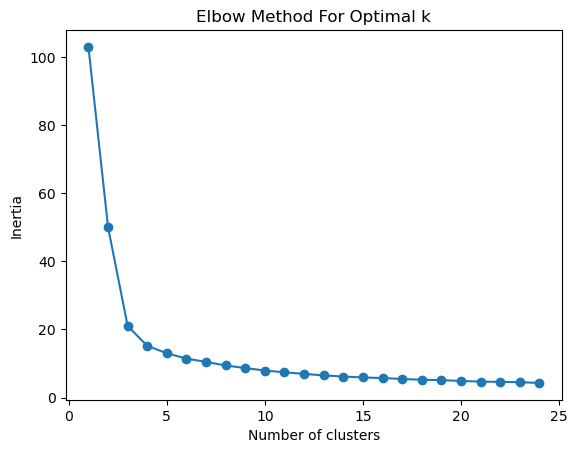

In [374]:
inertia = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 25), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

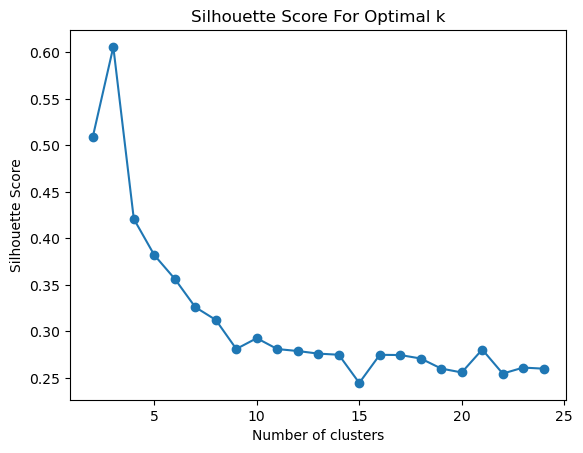

In [375]:
silhouette_scores = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, n_init=10)
    clusters = kmeans.fit_predict(df)
    silhouette_scores.append(silhouette_score(df, clusters))

plt.plot(range(2, 25), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

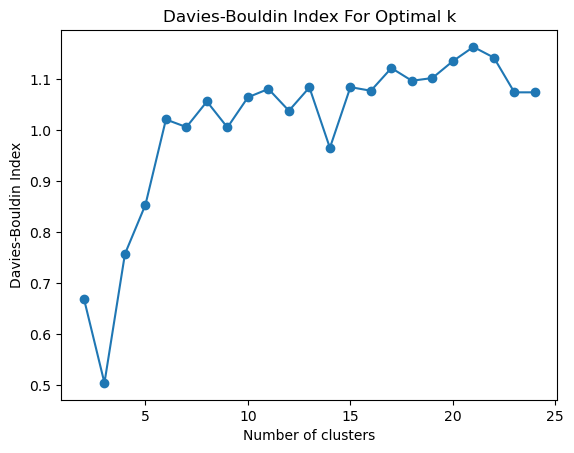

In [376]:
db_scores = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, n_init=10)
    clusters = kmeans.fit_predict(df)
    db_scores.append(davies_bouldin_score(df, clusters))

plt.plot(range(2, 25), db_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index For Optimal k')
plt.show()

# Hierarchical Clustering

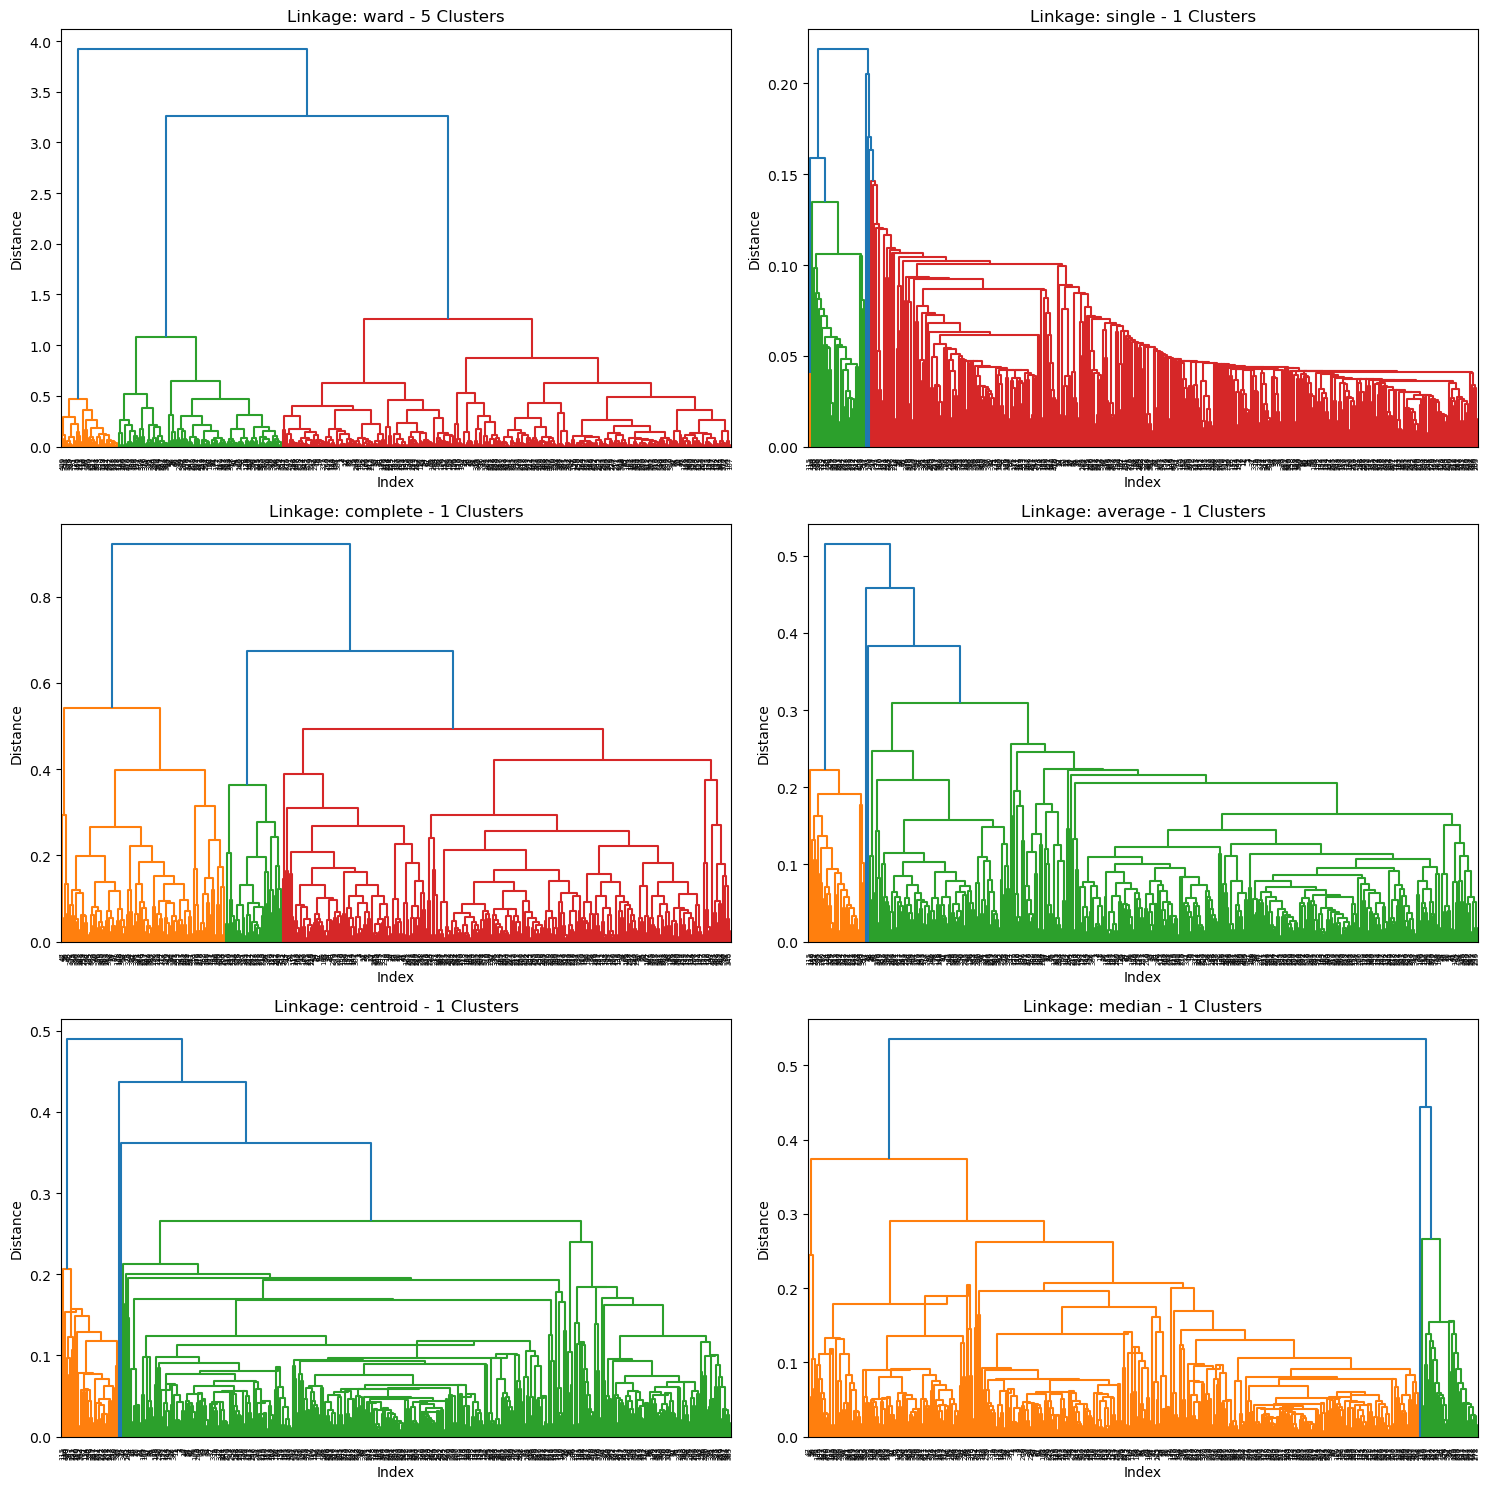

In [377]:
# Feature Scaling
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Define linkage methods
methods = ['ward', 'single', 'complete', 'average', 'centroid', 'median']

# Create a subplot for each method
plt.figure(figsize=(15, 15))

for i, method in enumerate(methods, 1):
    # Compute the linkage matrix
    linkage_matrix = linkage(df_scaled, method=method)

    # Form flat clusters and count the number of clusters
    distance_threshold = 1 # change this to change how many clusters are formed
    clusters = fcluster(linkage_matrix, distance_threshold, criterion='distance')
    num_clusters = len(np.unique(clusters))

    # Create a subplot for the dendrogram
    ax = plt.subplot(3, 2, i)
    dendrogram(linkage_matrix, ax=ax, labels=df.index, leaf_rotation=90)
    ax.set_title(f'Linkage: {method} - {num_clusters} Clusters')
    ax.set_xlabel('Index')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()

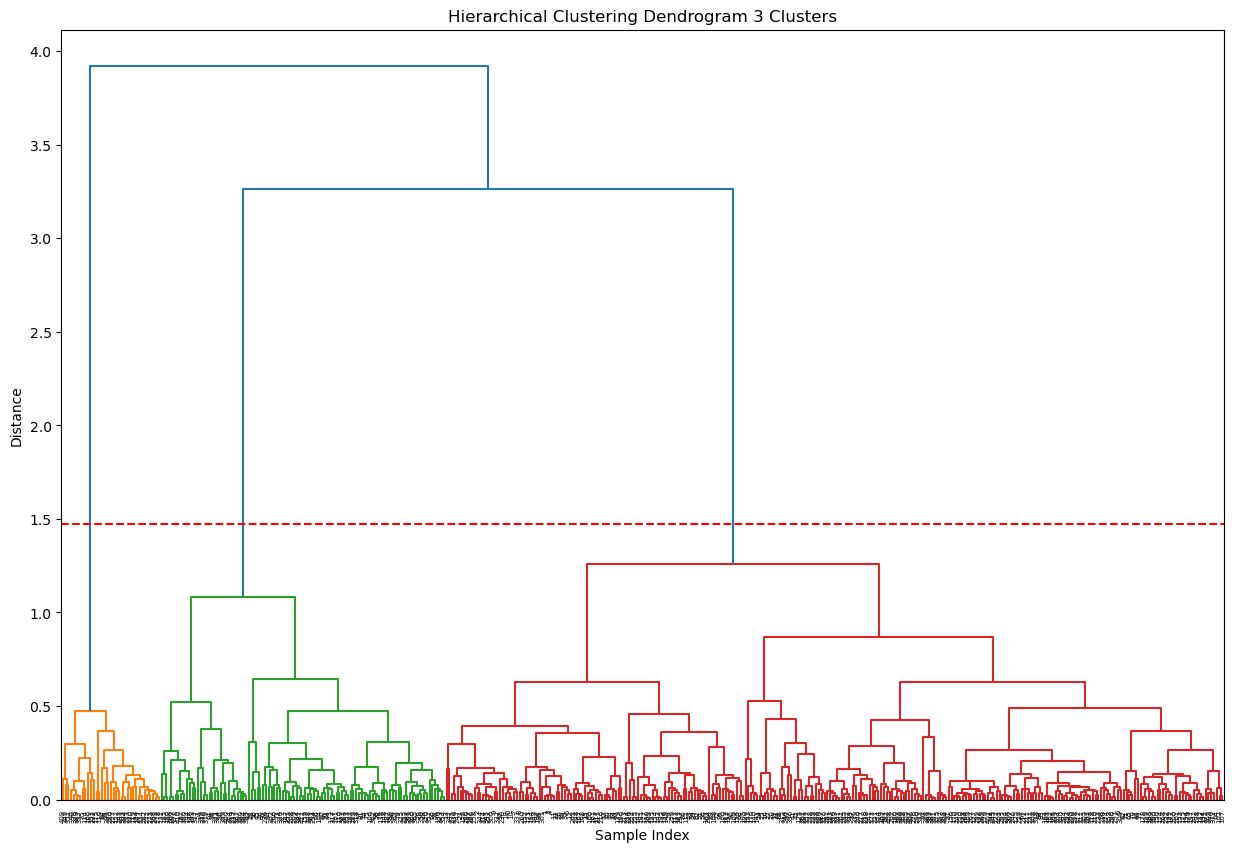

In [378]:
# Feature Scaling
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Perform hierarchical clustering
linkage_matrix = linkage(df_scaled, method='ward')

# Compute the inconsistency matrix
depth = 5  # Adjustable parameter
inconsistency_matrix = inconsistent(linkage_matrix, depth)

# Determine a threshold for clustering
inconsistency_threshold = 1.5 * np.average(inconsistency_matrix[:, 3]) # Adjustable parameter
clusters = fcluster(linkage_matrix, inconsistency_threshold, criterion='distance')
num_clusters = len(np.unique(clusters))

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, color_threshold=inconsistency_threshold)

# Draw a line at the cutoff distance
plt.axhline(y=inconsistency_threshold, color='r', linestyle='--')
plt.title(f'Hierarchical Clustering Dendrogram {num_clusters} Clusters')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

Method: ward, Large Cluster Sizes (sorted): [98, 65, 63, 43, 43, 35, 24, 18, 13, 5, 5]


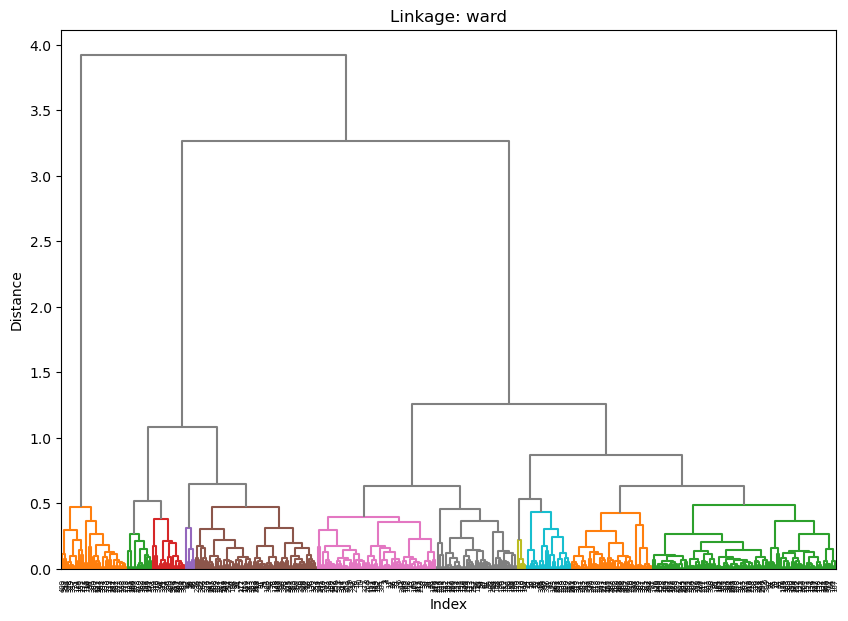

Method: single, Large Cluster Sizes (sorted): [412]


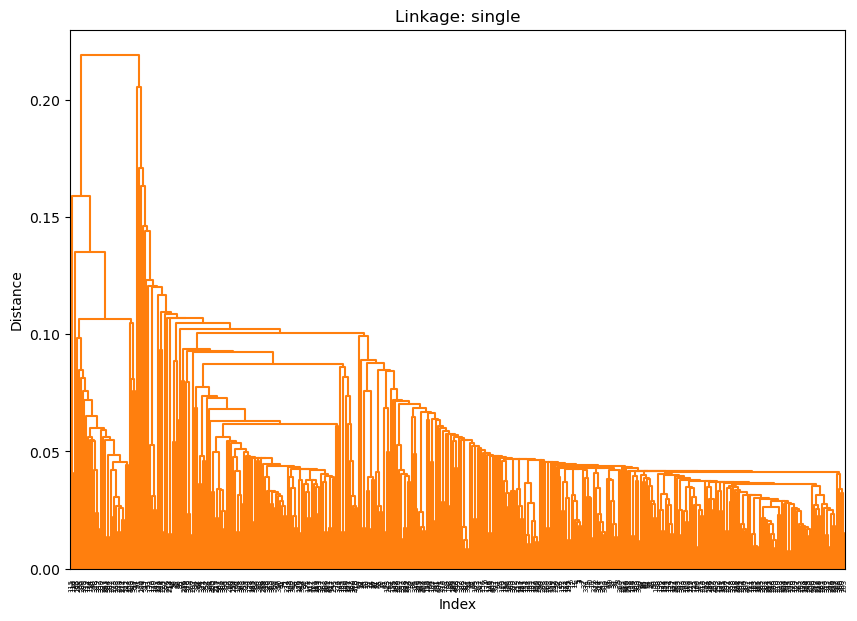

Method: complete, Large Cluster Sizes (sorted): [276, 96, 35, 5]


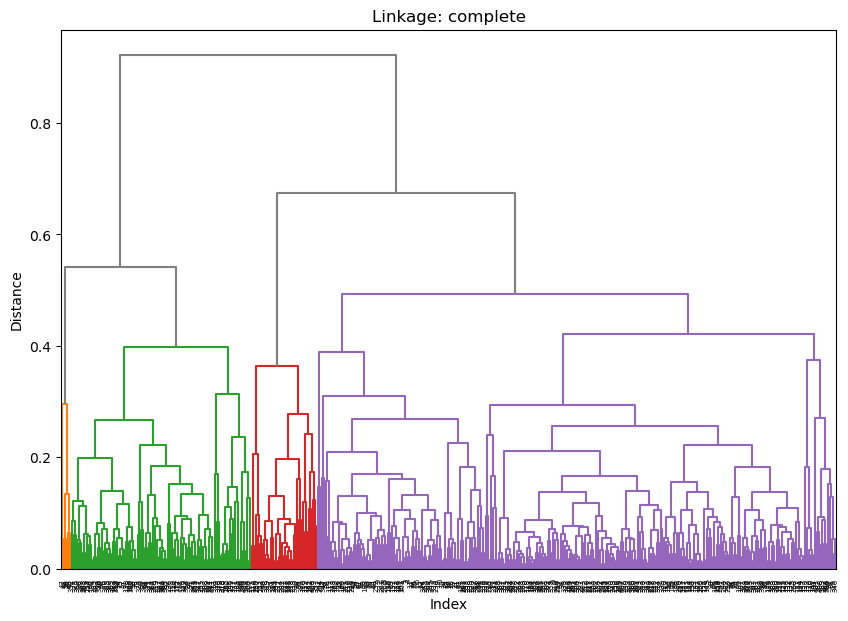

Method: average, Large Cluster Sizes (sorted): [377, 35]


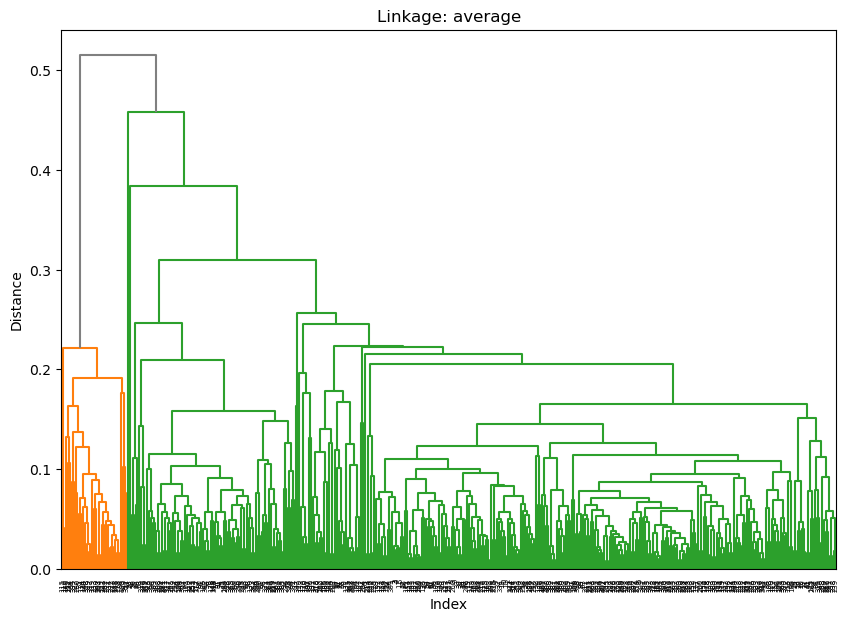

Method: centroid, Large Cluster Sizes (sorted): [412]


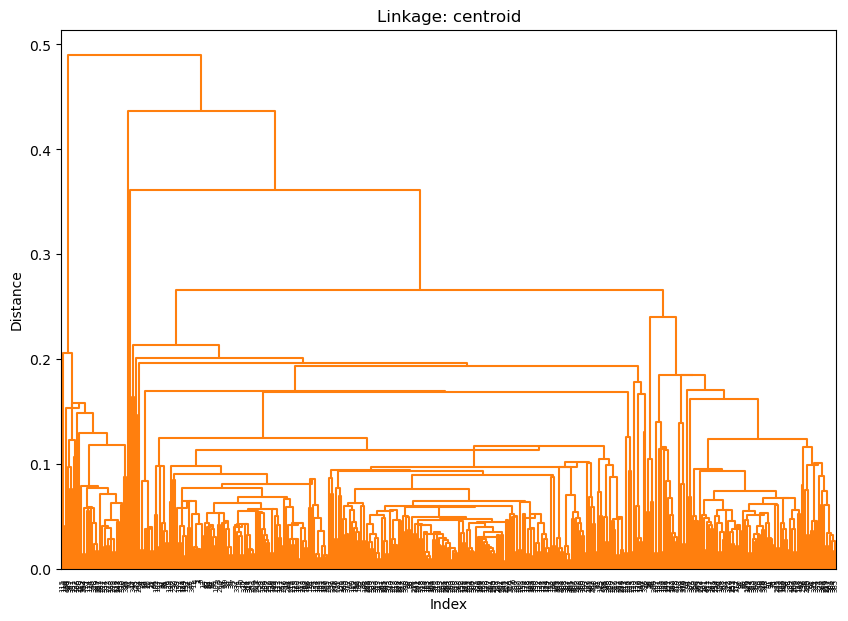

Method: median, Large Cluster Sizes (sorted): [376, 36]


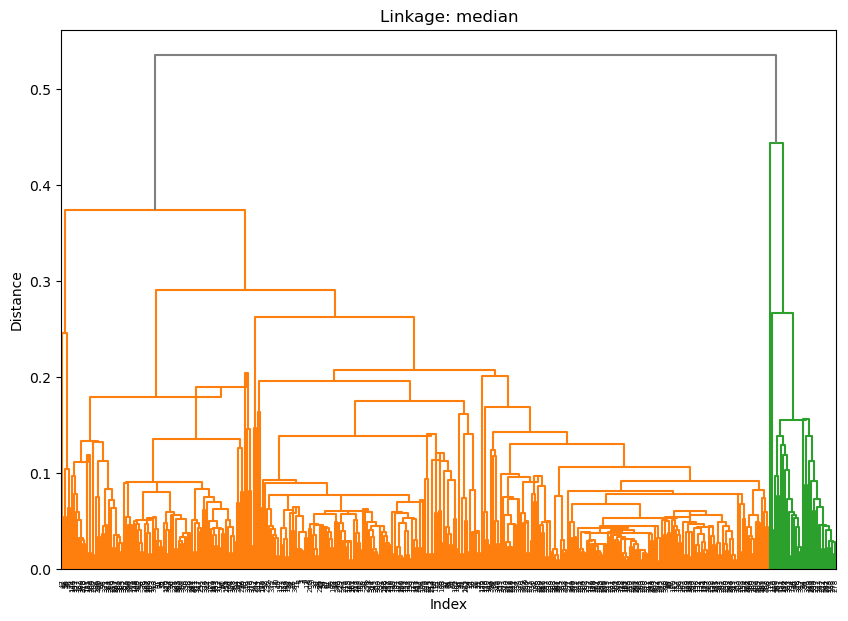

In [379]:
# Feature Scaling
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Define linkage methods
methods = ['ward', 'single', 'complete', 'average', 'centroid', 'median']

# Create a subplot for each method and list cluster sizes
for i, method in enumerate(methods, 1):
    # Compute the linkage matrix
    linkage_matrix = linkage(df_scaled, method=method)

    # Form flat clusters
    distance_threshold = 0.5  # Adjust this based on visual inspection of the dendrogram
    clusters = fcluster(linkage_matrix, distance_threshold, criterion='distance')

    # Adjust cluster labels for np.bincount
    clusters_adjusted = clusters - 1

    # Count the number of points in each cluster
    cluster_counts = np.bincount(clusters_adjusted)

    # Filter out small clusters
    small_cluster_threshold = 3  # Define what you consider as a small cluster
    large_clusters = np.where(cluster_counts >= small_cluster_threshold)[0]

    # Sort large clusters by size
    sorted_cluster_sizes = sorted(cluster_counts[large_clusters], reverse=True)

    # Print large cluster sizes for each method
    print(f"Method: {method}, Large Cluster Sizes (sorted): {sorted_cluster_sizes}\n")

    # Create a subplot for the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, 
               color_threshold=distance_threshold, above_threshold_color='grey')
    plt.title(f'Linkage: {method}')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.show()


Method: ward, Cluster Sizes (sorted): [276, 101, 35]


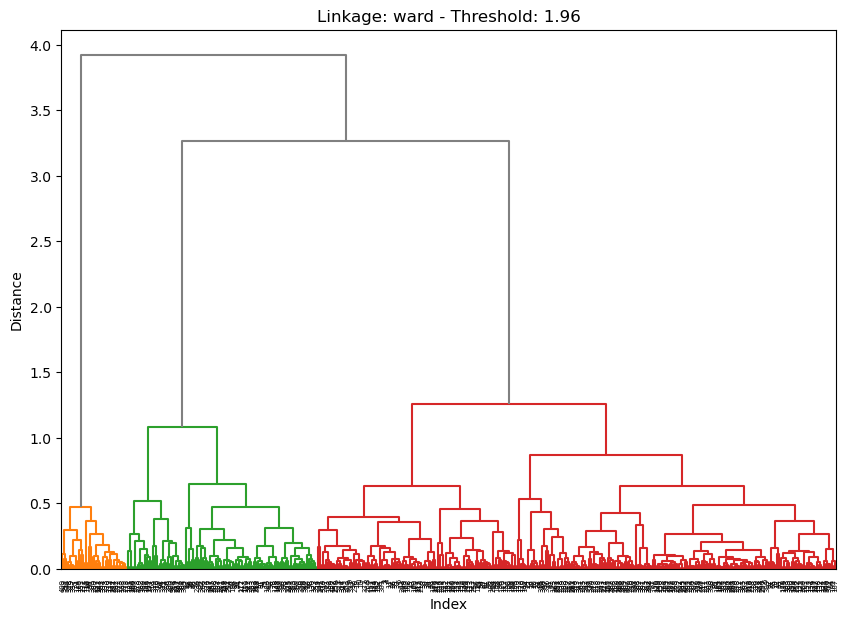

Method: single, Cluster Sizes (sorted): [365, 32, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


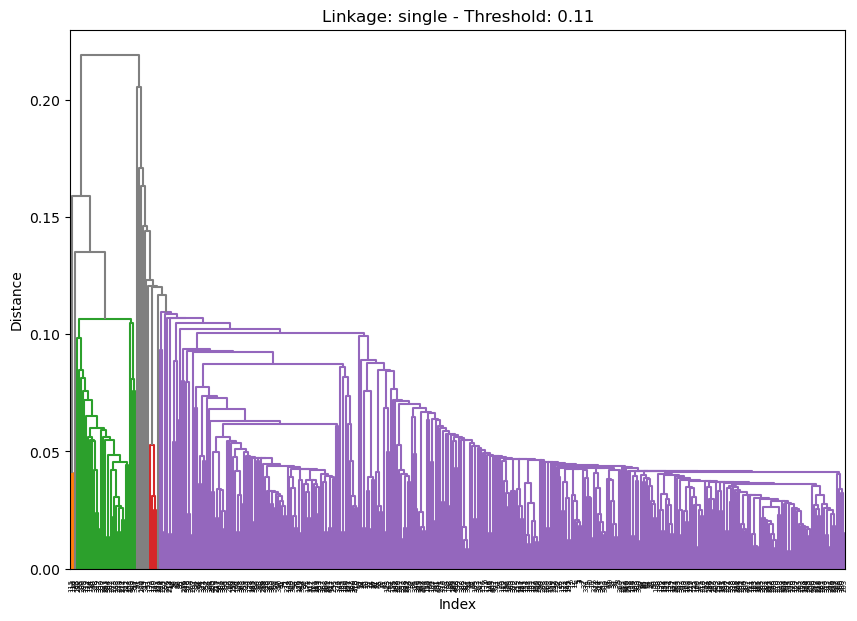

Method: complete, Cluster Sizes (sorted): [187, 96, 89, 35, 5]


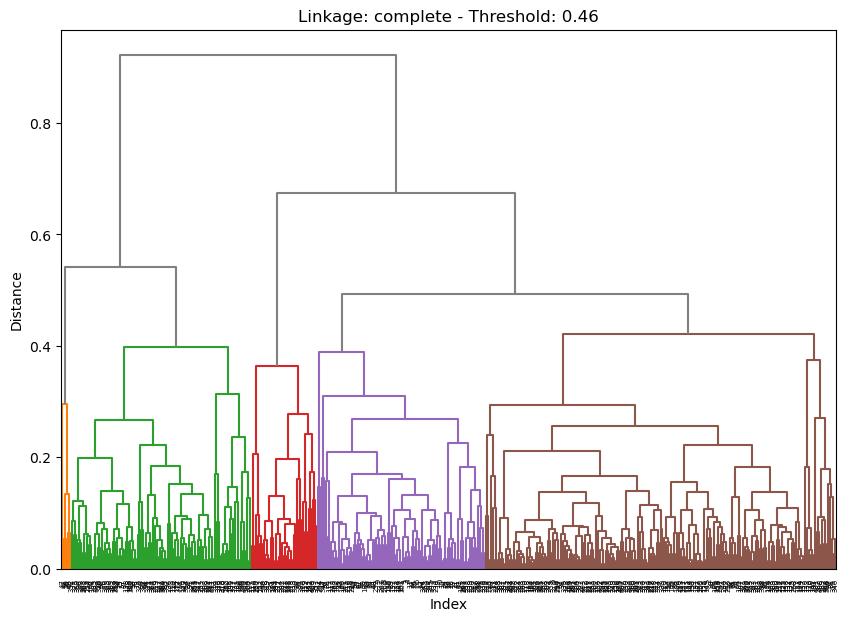

Method: average, Cluster Sizes (sorted): [288, 87, 35, 1, 1]


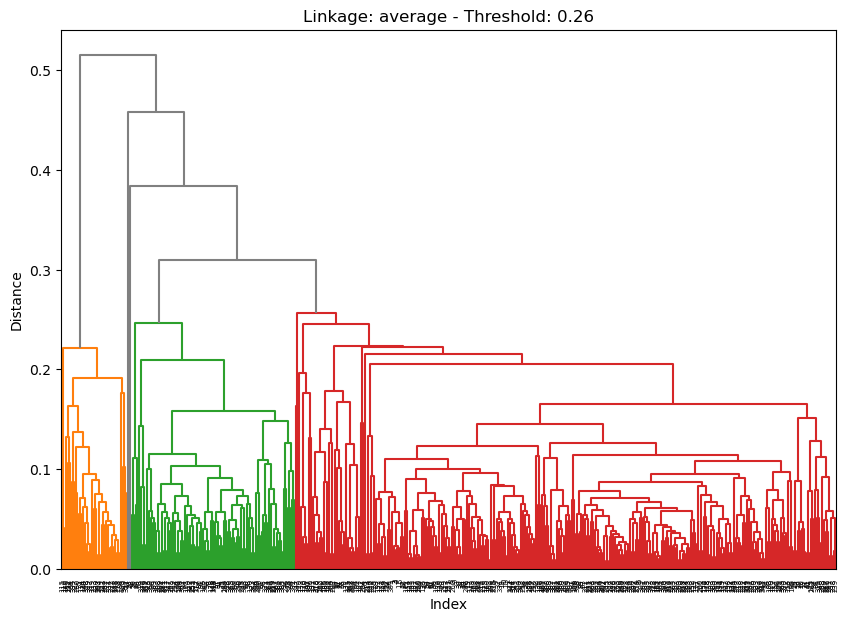

Method: centroid, Cluster Sizes (sorted): [274, 101, 35, 1, 1]


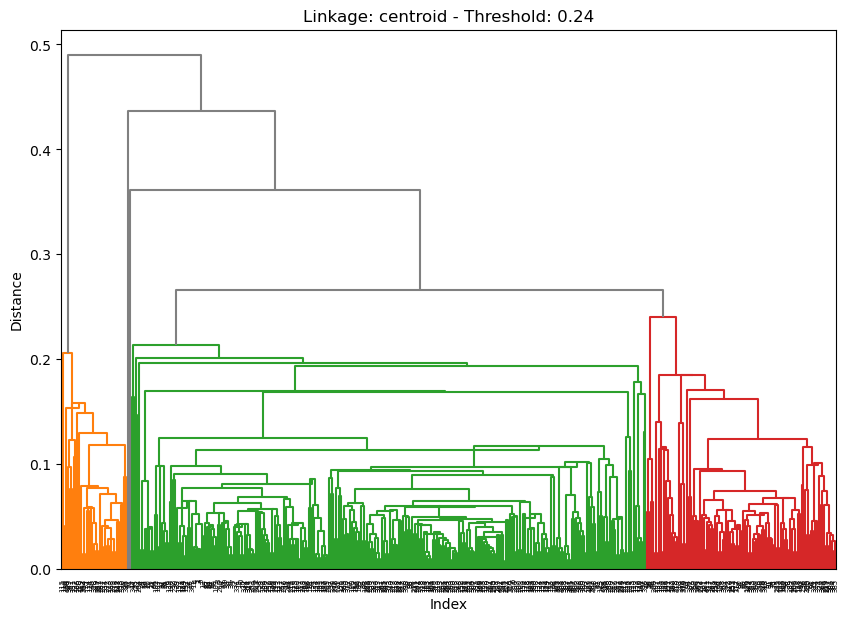

Method: median, Cluster Sizes (sorted): [274, 97, 35, 5, 1]


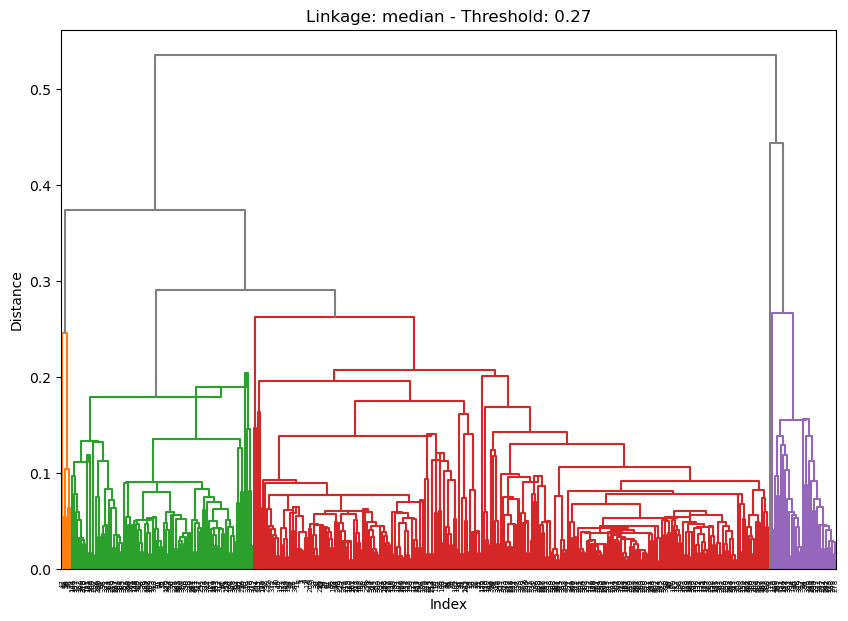

In [380]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Define linkage methods
methods = ['ward', 'single', 'complete', 'average', 'centroid', 'median']

# Percentage of the maximum distance to use as threshold
percentage_threshold = 0.5  # for example, 10% of the maximum distance

# Create a subplot for each method and list cluster sizes
for i, method in enumerate(methods, 1):
    # Compute the linkage matrix
    linkage_matrix = linkage(df_scaled, method=method)

    # Calculate dynamic distance threshold based on the maximum distance
    max_distance = np.max(linkage_matrix[:, 2])
    dynamic_threshold = max_distance * percentage_threshold

    # Form flat clusters
    clusters = fcluster(linkage_matrix, dynamic_threshold, criterion='distance')

    # Adjust cluster labels for np.bincount
    clusters_adjusted = clusters - 1

    # Count the number of points in each cluster
    cluster_counts = np.bincount(clusters_adjusted)

    # Sort clusters by size
    sorted_cluster_sizes = sorted(cluster_counts, reverse=True)

    # Print cluster sizes for each method
    print(f"Method: {method}, Cluster Sizes (sorted): {sorted_cluster_sizes}\n")

    # Create a subplot for the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, 
               color_threshold=dynamic_threshold, above_threshold_color='grey')
    plt.title(f'Linkage: {method} - Threshold: {dynamic_threshold:.2f}')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.show()


# DBSCAN

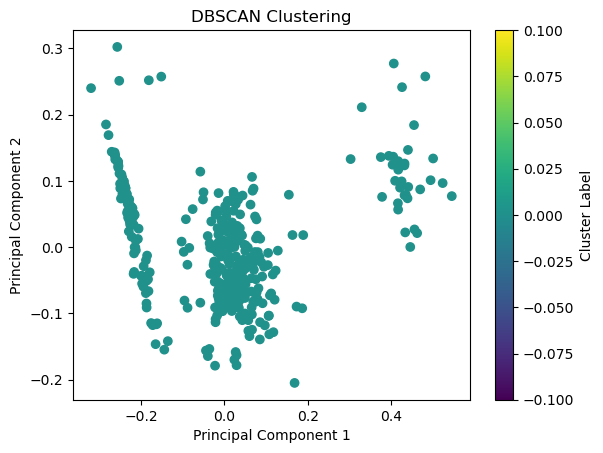

In [381]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_scaled)

# Reduce dimensions for visualization (using PCA)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plotting
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster Label')
plt.show()

Cluster Summary Statistics:
                 Fe         C        Si        Mn         P         S  \
Cluster                                                                
0        98.519061  0.195726  0.239302  0.597264  0.024849  0.038941   

               Cr        Mo       Ni        Al  ...        Ti         V     W  \
Cluster                                         ...                             
0        0.017248  0.004118  0.05003  0.004944  ...  0.001633  0.002289  0.04   

            Pb        Sn        B        Ca        Zr        As        Bi  
Cluster                                                                    
0        0.015  0.014373  0.00196  0.001194  0.002394  0.039711  0.017551  

[1 rows x 23 columns]
Silhouette plot cannot be generated for a single cluster or only noise.


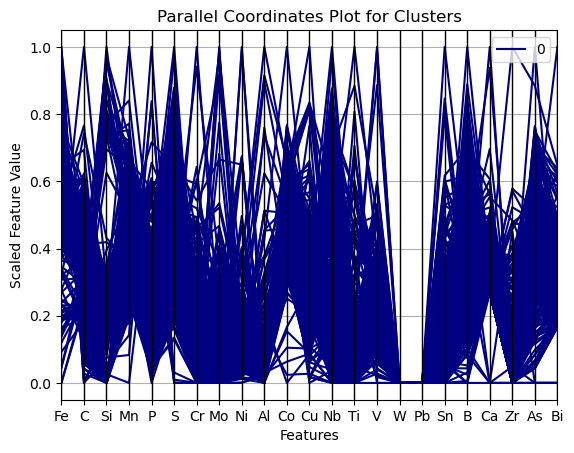

In [382]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=5)
clusters = dbscan.fit_predict(df_scaled)

# 1. Cluster Summary Statistics
# Adding cluster labels to the original DataFrame
df['Cluster'] = clusters

# Summary statistics for each cluster
cluster_summary = df.groupby('Cluster').mean()
print("Cluster Summary Statistics:\n", cluster_summary)

# 2. Silhouette Plots
if len(np.unique(clusters)) > 1:
    silhouette_vals = silhouette_samples(df_scaled, clusters)
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(clusters)):
        cluster_silhouette_vals = silhouette_vals[clusters == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        color = cm.jet(float(i) / len(np.unique(clusters)))
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(y_ticks, np.unique(clusters))
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.title('Silhouette Plot')
    plt.show()
else:
    print("Silhouette plot cannot be generated for a single cluster or only noise.")

# 3. Parallel Coordinates Plot
# Scaling the data for parallel coordinates plot
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df.iloc[:, :-1]), columns=df.columns[:-1])
df_normalized['Cluster'] = df['Cluster']

# Plotting
parallel_coordinates(df_normalized, 'Cluster', colormap='jet')
plt.xlabel('Features')
plt.ylabel('Scaled Feature Value')
plt.title('Parallel Coordinates Plot for Clusters')
plt.show()

# Gaussian Mixture Models

In [383]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Number of components (clusters) to fit
n_components = 8 # Adjustable parameter

# Create and fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(df_scaled)

# Predict the cluster for each data point
clusters = gmm.predict(df_scaled)

# count the number of points in each cluster
cluster_counts = np.bincount(clusters)

# sort clusters by size
cluster_counts = sorted(cluster_counts, reverse=True)
cluster_counts

[136, 70, 53, 51, 35, 30, 28, 9]

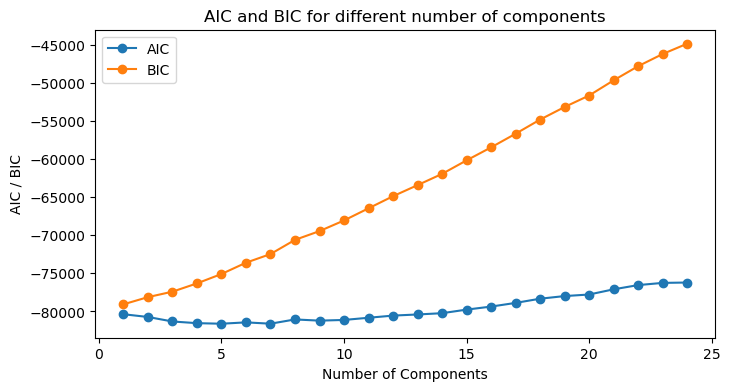

In [384]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Range of potential components
n_components_range = range(1, 25)  # Adjust this range as needed

# Lists to store AIC and BIC values
aics = []
bics = []

# Fit GMM models with different number of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(df_scaled)
    aics.append(gmm.aic(df_scaled))
    bics.append(gmm.bic(df_scaled))

# Plotting the AIC and BIC values
plt.figure(figsize=(8, 4))
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('AIC / BIC')
plt.legend()
plt.title('AIC and BIC for different number of components')
plt.show()

# t-SNE

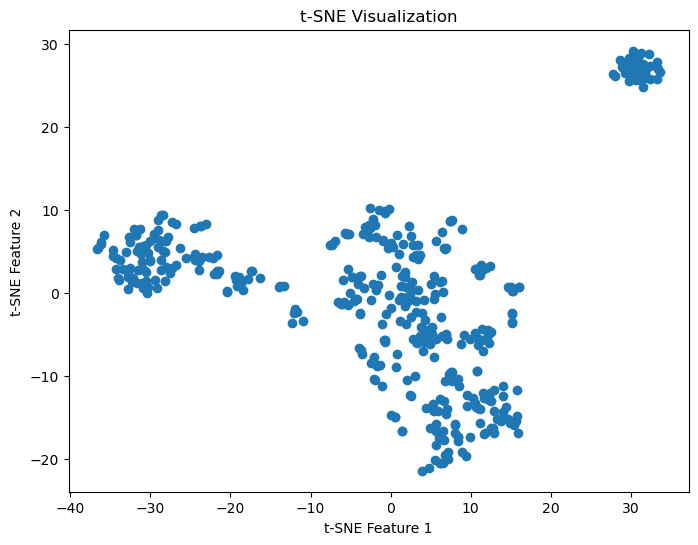

In [385]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
df_tsne = tsne.fit_transform(df_scaled)

# Plotting the t-SNE reduced data
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1])
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization')
plt.show()

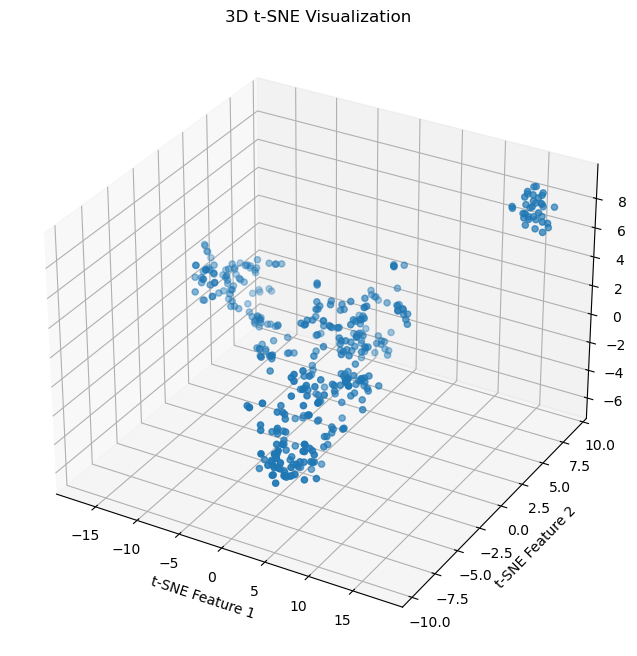

In [386]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Apply t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=0)
df_tsne_3d = tsne.fit_transform(df_scaled)

# Plotting the t-SNE reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_tsne_3d[:, 0], df_tsne_3d[:, 1], df_tsne_3d[:, 2])
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_zlabel('t-SNE Feature 3')
plt.title('3D t-SNE Visualization')
plt.show()

# Spectral Clustering

In [387]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Apply Spectral Clustering
n_clusters = 2  # Adjustable parameter
n_neighbors = 5  # Adjustable parameter
spectral_clust = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=n_neighbors, random_state=0)
clusters = spectral_clust.fit_predict(df_scaled)

# count the number of points in each cluster
cluster_counts = np.bincount(clusters)

# sort clusters by size
cluster_counts = sorted(cluster_counts, reverse=True)
cluster_counts

[377, 35]

In [388]:
# remove
import warnings
warnings.filterwarnings('ignore')

# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

range_n_clusters = range(2,20)  # Adjust this range as needed
range_n_neighbors = range(1,50)  # Adjust this range as needed

best_score = -1
best_clusters = 0
best_neighbors = 0

for n_clusters in range_n_clusters:
    for n_neighbors in range_n_neighbors:
        spectral = SpectralClustering(n_clusters=n_clusters, n_neighbors=n_neighbors, affinity='nearest_neighbors', random_state=0)
        cluster_labels = spectral.fit_predict(df_scaled)
        silhouette_avg = silhouette_score(df_scaled, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_clusters = n_clusters
            best_neighbors = n_neighbors

print(f"Best Silhouette Score: {best_score}")
print(f"Optimal number of clusters: {best_clusters}")
print(f"Optimal number of neighbors: {best_neighbors}")

Best Silhouette Score: 0.5986973948602654
Optimal number of clusters: 2
Optimal number of neighbors: 5


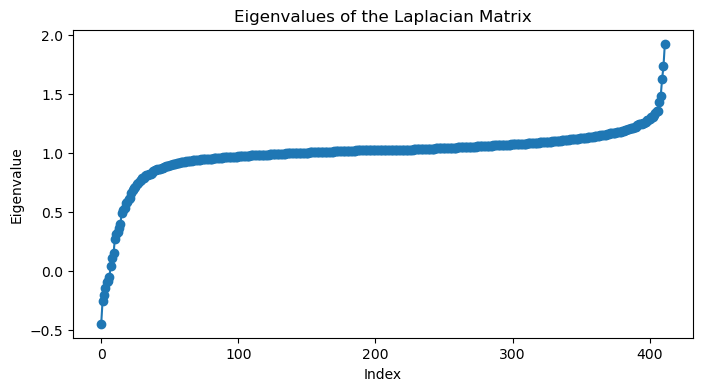

Optimal number of clusters: 1


In [389]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Construct the similarity graph
n_neighbors = 40  # Adjust based on your dataset
connectivity = kneighbors_graph(df_scaled, n_neighbors=n_neighbors, include_self=True)

# Compute the Laplacian matrix
laplacian_matrix, _ = laplacian(connectivity, normed=True, return_diag=True)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix.toarray())

# Sort the eigenvalues
sorted_eigenvalues = np.sort(eigenvalues)

# Plot the sorted eigenvalues
plt.figure(figsize=(8, 4))
plt.plot(sorted_eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Laplacian Matrix')
plt.show()

# The number of clusters is often one more than the index of the largest gap between successive eigenvalues
# Identify the index of the largest gap
index_of_largest_gap = np.argmax(np.diff(sorted_eigenvalues))
optimal_clusters = index_of_largest_gap + 1

print(f"Optimal number of clusters: {optimal_clusters}")

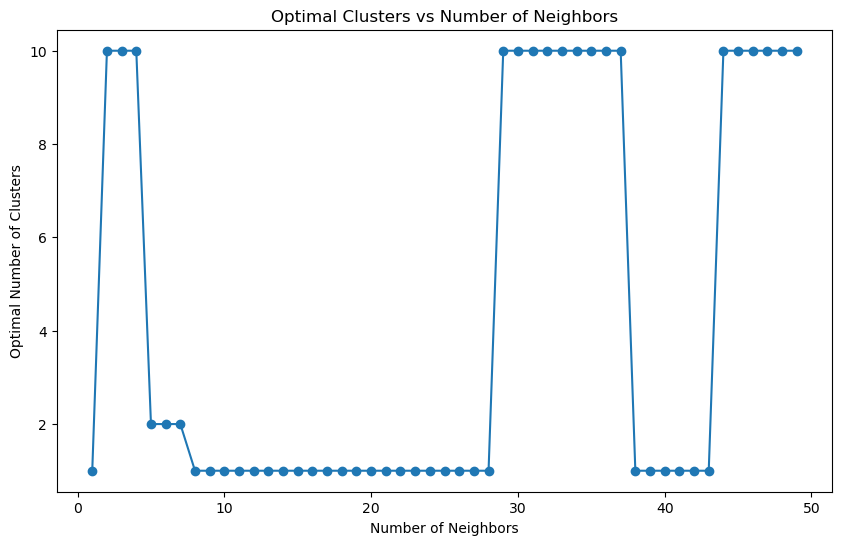

The number of clusters is capped at 10 since for some number of neighbours the optimal number of clusters is 100+ and often one cluster per datapoint. Adjust the if condition in the for loop to change this.


In [393]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Range of neighbors to try
n_neighbors_range = range(1, 50)

# Store the optimal clusters for each n_neighbors
optimal_clusters_per_n = {}

for n_neighbors in n_neighbors_range:
    # Construct the similarity graph
    connectivity = kneighbors_graph(df_scaled, n_neighbors=n_neighbors, include_self=True)

    # Compute the Laplacian matrix
    laplacian_matrix, _ = laplacian(connectivity, normed=True, return_diag=True)

    # Ensure Laplacian matrix is 2D and not too small
    if laplacian_matrix.ndim == 2 and laplacian_matrix.shape[0] > 1:
        # Convert to dense matrix
        laplacian_dense = laplacian_matrix.toarray()

        # Compute eigenvalues
        eigenvalues = np.linalg.eigvalsh(laplacian_dense)

        # Sort the eigenvalues
        sorted_eigenvalues = np.sort(eigenvalues)

        # Identify the index of the largest gap
        index_of_largest_gap = np.argmax(np.diff(sorted_eigenvalues))
        optimal_clusters = index_of_largest_gap + 1

        # Store the result
        if optimal_clusters < 10:
            optimal_clusters_per_n[n_neighbors] = optimal_clusters
        else:
            optimal_clusters_per_n[n_neighbors] = 10
        

# Plot the optimal number of clusters for each n_neighbors
plt.figure(figsize=(10, 6))
plt.plot(list(n_neighbors_range), list(optimal_clusters_per_n.values()), marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Optimal Number of Clusters')
plt.title('Optimal Clusters vs Number of Neighbors')
plt.show()
print("The number of clusters is capped at 10 since for some number of neighbours the optimal number of clusters is 100+ and often one cluster per datapoint. Adjust the if condition in the for loop to change this.")

# SOM

## Not well implemented yet, needs to be changed to work with the data or dropped

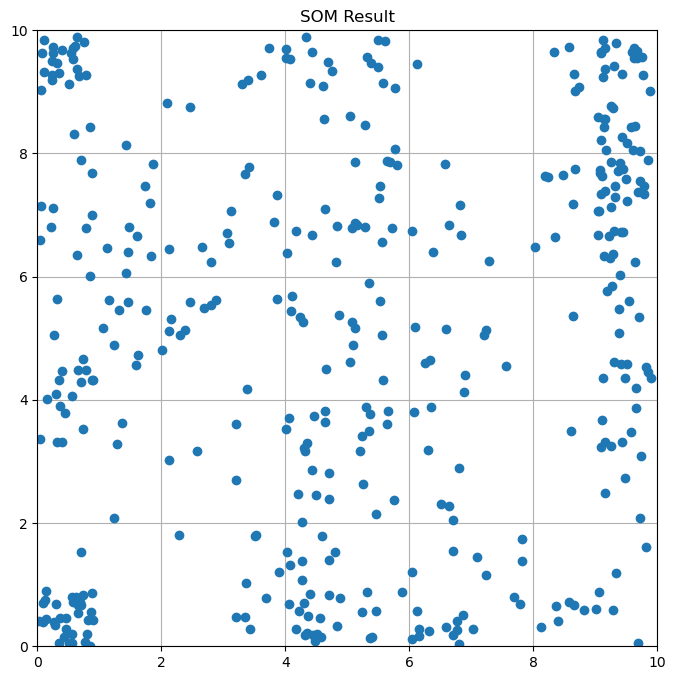

In [391]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# Map Size based on heuristic
N = len(df_scaled)
size = int(math.sqrt(5 * math.sqrt(N)))

# SOM initialization with increased sigma
som = MiniSom(size, size, df_scaled.shape[1], sigma=5.0, learning_rate=0.9, 
              neighborhood_function='gaussian', random_seed=42)

# Random or PCA-based initialization
# som.random_weights_init(df_scaled)

# Increase the number of iterations
som.train_random(df_scaled, num_iteration=1000000)

# Visualizing the results
plt.figure(figsize=(8, 8))
for i, x in enumerate(df_scaled):
    winning_node = som.winner(x)
    plt.plot(winning_node[0] + np.random.rand() * .9, winning_node[1] + np.random.rand() * .9, marker='o', color='C0')
plt.xlim(0, size)
plt.ylim(0, size)
plt.grid()
plt.title('SOM Result')
plt.show()

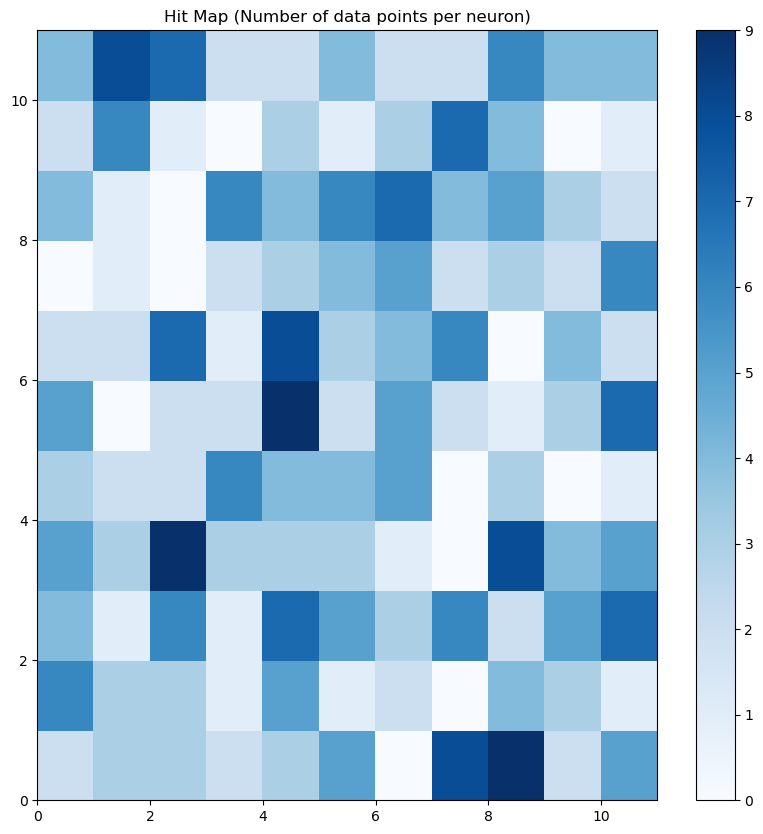

In [392]:
# Standardizing the Data
scaler = FunctionTransformer(np.log1p, validate=True)
df_scaled = scaler.fit_transform(df)

# SOM initialization
som_size = 11  # Size of the SOM grid
som = MiniSom(som_size, som_size, df_scaled.shape[1], sigma=2.0, learning_rate=0.5, random_seed=0)
som.random_weights_init(df_scaled)

# Training the SOM
som.train_random(df_scaled, num_iteration=1000000)

# Creating a hit map
hit_map = np.zeros((som_size, som_size))
for x in df_scaled:
    winner = som.winner(x)
    hit_map[winner] += 1

# Plotting the hit map
plt.figure(figsize=(10, 10))
plt.pcolor(hit_map, cmap='Blues')
plt.colorbar()
plt.title('Hit Map (Number of data points per neuron)')
plt.show()
